In [320]:
import pandas as pd
import random
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


In [321]:
# Get S&P 500 tickers 
def get_sp500_tickers(sample_size=500):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)[0]    
    tickers = table['Symbol'].tolist()
    sample_tickers = random.sample(tickers, sample_size)
    return sample_tickers

In [322]:
# Fetch historical data
def get_historical_data(tickers):
    data = pd.DataFrame()
    for i in tickers:
        stock_data = yf.download(i, start="2021-01-01", end="2024-09-30")
        data[i] = stock_data['Adj Close']
    return data

In [323]:
# Perform the ADF test for stationarity
def adf_test(series):         
    result = adfuller(series)
    return result[1]  # Return p-value

In [324]:
# Calculate z-score for the residuals
def calculate_zscore(residuals):
    mean = residuals.rolling(window=50).mean()
    std = residuals.rolling(window=50).std()
    zscore = (residuals - mean) / std
    return zscore

In [325]:
# Function to calculate half-life based on residuals
def calculate_half_life(residuals):
    residuals_lag = residuals.shift(1).dropna()
    delta_residuals = (residuals - residuals_lag).dropna()
    
    # Regress delta_residuals on residuals_lag to estimate half-life
    regression = OLS(delta_residuals, residuals_lag).fit() # fit() method is called on this object for fitting the regression line to the data.
    half_life = -np.log(2) / regression.params[0] # -ln(2)/slope of the regression
    
    return half_life

In [326]:
def get_start_dates(data):
    start_dates = {}
    for ticker in data.columns:
        start_date = data[ticker].first_valid_index()  # Get the first valid index (date)
        if start_date is not None:
            start_dates[ticker] = start_date.strftime('%Y-%m-%d')  # Convert to string format
        else:
            start_dates[ticker] = None  # Handle cases with no valid dates
    return start_dates

In [327]:
# Cointegration test between pairs of stocks with ADF and half-life calculation
def cointegration_test(data, start_dates):
    pairs = []
    results = []
    residuals_dict = {}

    tickers = data.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            x = data[tickers[i]].dropna()
            y = data[tickers[j]].dropna()

            # Align x and y by matching labels (dates)
            x, y = x.align(y, join='inner')

            # Check if start dates are the same
            if start_dates[tickers[i]] != start_dates[tickers[j]]:
                continue  # Disconsider this pair if start dates are not the same

            # Skip to the next pair if x and y do not have the same size
            if len(x) != len(y) or x.empty or y.empty:
                continue

            try:
                # Perform the cointegration test
                score, p_value, _ = coint(x, y)
            except ValueError:
                continue

            if p_value < 0.05:  # Cointegration threshold
                # Ratio between the two prices
                ratio = x / y
                adf_p_value = adf_test(ratio)

                if adf_p_value < 0.05:  # ADF stationarity threshold
                    # Store the residuals from the OLS regression
                    ols_result = OLS(x, y).fit()
                    residuals = ols_result.resid

                    # Calculate half-life based on residuals
                    half_life = calculate_half_life(residuals)

                    pairs.append((tickers[i], tickers[j]))
                    results.append((tickers[i], tickers[j], score, p_value, adf_p_value, half_life))
                    residuals_dict[(tickers[i], tickers[j])] = residuals

    results_df = pd.DataFrame(results, columns=['Stock 1', 'Stock 2', 'Cointegration Score', 'Cointegration p-value', 'ADF p-value', 'Half-life'])
    return results_df, residuals_dict

In [328]:
# Get S&P 500 tickers and historical data
ticks = get_sp500_tickers()
historical_data = get_historical_data(ticks)

# Get start dates for each stock
start_dates = get_start_dates(historical_data)

# Cointegration test
results_df, residuals_dict = cointegration_test(historical_data, start_dates)

# Filter pairs based on cointegration first
cointegrated_pairs = results_df[results_df['Cointegration p-value'] < 0.05]

# Among cointegrated pairs, apply ADF test and half-life ranking
adf_filtered_results = cointegrated_pairs[cointegrated_pairs['ADF p-value'] < 0.05]

# Sort by half-life to prioritize pairs with faster mean reversion
sorted_results = adf_filtered_results.sort_values(by='Half-life', ascending=True)

print(len(ticks))
print("historical_data:", historical_data.head())
print("results_df:", results_df.head())
print("cointegrated_pairs:", cointegrated_pairs.head())
print("adf_filtered_results", adf_filtered_results.head())
print("sorted_results", adf_filtered_results.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [298]:
# Get the top cointegrated pair
top_pair = sorted_results.iloc[0]
stock1, stock2 = top_pair['Stock 1'], top_pair['Stock 2']

# Generate residuals
residuals = residuals_dict[(stock1, stock2)]

# Calculate z-score of the residuals
zscore = calculate_zscore(residuals)

stock1_prices = historical_data[stock1]  # Access the price series for stock1
stock2_prices = historical_data[stock2]  # Access the price series for stock2

print(stock1_prices)
print(stock2_prices)

Date
2021-01-04    103.185959
2021-01-05    104.837067
2021-01-06    107.322624
2021-01-07    110.367867
2021-01-08    110.724045
                 ...    
2024-09-23    172.740005
2024-09-24    171.110001
2024-09-25    168.110001
2024-09-26    167.949997
2024-09-27    166.710007
Name: DRI, Length: 940, dtype: float64
Date
2021-01-04    186.564651
2021-01-05    187.198380
2021-01-06    191.992661
2021-01-07    192.194733
2021-01-08    191.919235
                 ...    
2024-09-23    255.191589
2024-09-24    257.050964
2024-09-25    256.593567
2024-09-26    260.511200
2024-09-27    262.470001
Name: ITW, Length: 940, dtype: float64


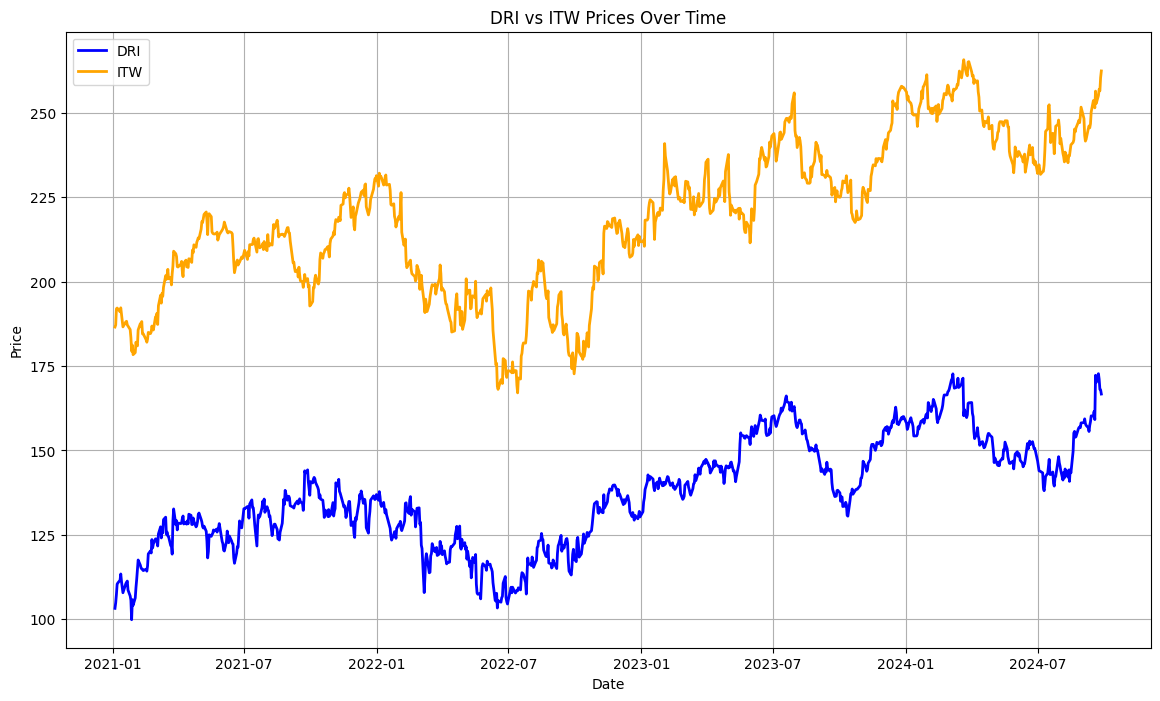

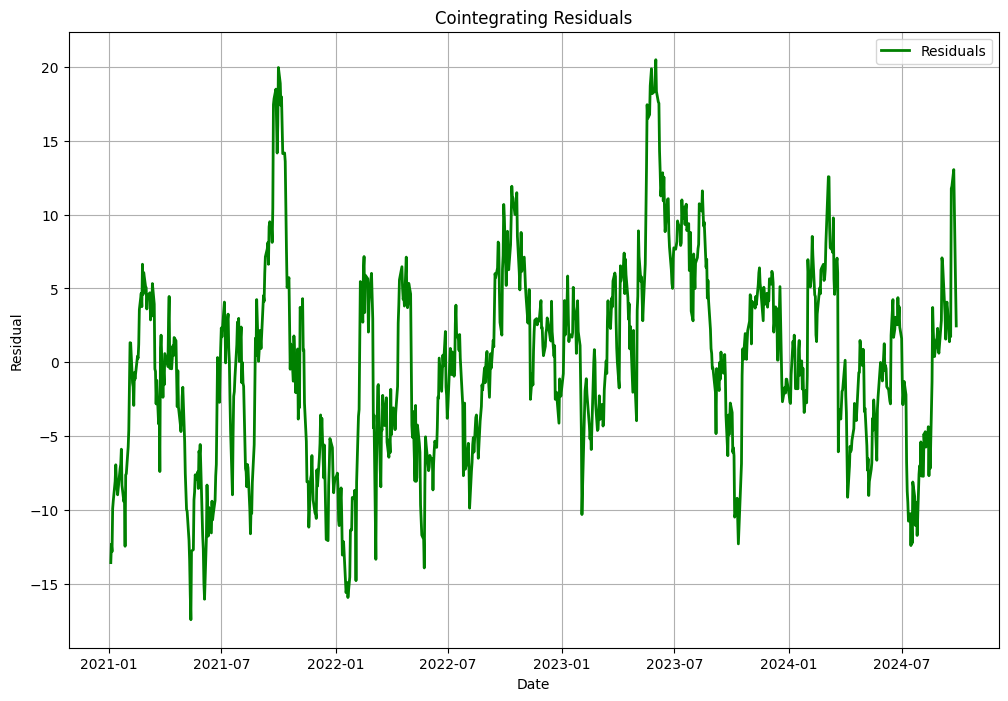

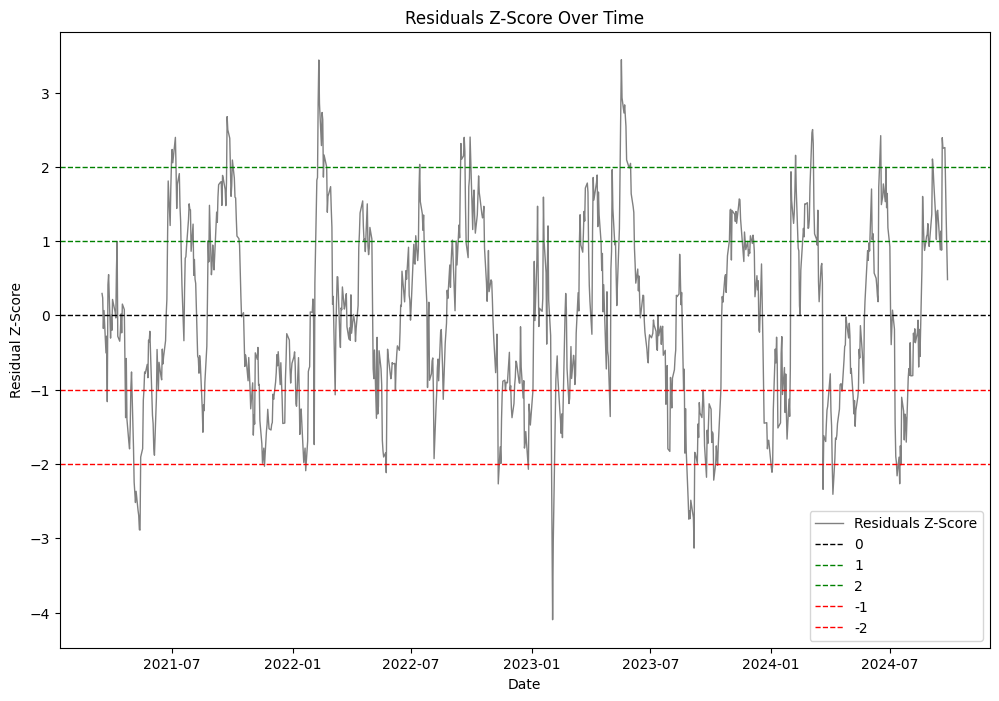

In [299]:
# Plot Stock 1 and Stock 2 Prices
def plot_stocks(stock1, stock2, historical_data):
    plt.figure(figsize=(14, 8))
    
    # Plot stock1 price
    plt.plot(historical_data[stock1], label=stock1, color='blue', linewidth=2)
    
    # Plot stock2 price
    plt.plot(historical_data[stock2], label=stock2, color='orange', linewidth=2)
    
    # Labels and title
    plt.title(f'{stock1} vs {stock2} Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Residuals
def plot_residuals(residuals):
    plt.figure(figsize=(12, 8))
    
    # Plot the residuals of Stock 1 to Stock 2
    plt.plot(residuals, label='Residuals', color='green', linewidth=2)
    
    # Labels and title
    plt.title('Cointegrating Residuals')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot residuals zscore
def plot_zscore(zscore):
    plt.figure(figsize=(12, 8))
    plt.plot(zscore, label='Residuals Z-Score', color='gray', linewidth=1)
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='0')
    plt.axhline(y=1, color='green', linestyle='--', linewidth=1, label='1')
    plt.axhline(y=2, color='green', linestyle='--', linewidth=1, label='2')
    plt.axhline(y=-1, color='red', linestyle='--', linewidth=1, label='-1')
    plt.axhline(y=-2, color='red', linestyle='--', linewidth=1, label='-2')

    # Labels and title
    plt.title('Residuals Z-Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual Z-Score')
    plt.legend()
    plt.show()

# Call the functions to plot
plot_stocks(stock1, stock2, historical_data)
plot_residuals(residuals)
plot_zscore(zscore)

In [300]:
# Define backtest using z-score signals
def backtest_zscore_strategy(stock1_prices, stock2_prices, zscore_residuals):
    positions = []
    returns = []

    position = None
    entry_stock1_price = None
    entry_stock2_price = None

    for i in range(len(zscore_residuals)):
        # Exit long position when z-score goes above 0 (mean reversion)
        if position == 'long' and zscore_residuals.iloc[i] >= 0:
            exit_stock1_price = stock1_prices.iloc[i]
            exit_stock2_price = stock2_prices.iloc[i]

            # Calculate return for the long position
            long_return = (exit_stock1_price - entry_stock1_price) / entry_stock1_price
            short_return = (entry_stock2_price - exit_stock2_price) / entry_stock2_price
            returns.append(long_return + short_return)
            positions.append(('exit', i))

            position = None  # Exit the position
            continue  # Skip to the next iteration after exiting

        # Exit short position when z-score goes below 0 (mean reversion)
        elif position == 'short' and zscore_residuals.iloc[i] <= 0:
            exit_stock1_price = stock1_prices.iloc[i]
            exit_stock2_price = stock2_prices.iloc[i]

            # Calculate return for the short position
            short_return = (entry_stock1_price - exit_stock1_price) / entry_stock1_price
            long_return = (exit_stock2_price - exit_stock2_price) / entry_stock2_price
            returns.append(short_return + long_return)
            positions.append(('exit', i))

            position = None  # Exit the position
            continue  # Skip to the next iteration after exiting

        # Check for new signals only if there's no active position
        if position is None:
            if zscore_residuals.iloc[i] < -1:
                # Enter long (Long Stock 1, Short Stock 2)
                entry_stock1_price = stock1_prices.iloc[i]
                entry_stock2_price = stock2_prices.iloc[i]
                position = 'long'
                positions.append(('long', i))

            elif zscore_residuals.iloc[i] > 1:
                # Enter short (Short Stock 1, Long Stock 2)
                entry_stock1_price = stock1_prices.iloc[i]
                entry_stock2_price = stock2_prices.iloc[i]
                position = 'short'
                positions.append(('short', i))

    return positions, returns

# Run backtest on full data
positions, returns = backtest_zscore_strategy(stock1_prices, stock2_prices, zscore)

# Convert returns to pandas Series
returns = pd.Series(returns)

# Calculating risk-free rate
risk_free_rate = 0.02  # Assuming a 2% annual risk-free rate
daily_risk_free_rate = (1 + risk_free_rate) ** (1 / 252) - 1  # Adjusted for daily returns

# Excess returns (returns - daily risk-free rate)
excess_returns = returns - daily_risk_free_rate

# Mean of excess returns
mean_excess_return = excess_returns.mean()

# Standard deviation of returns (volatility)
volatility = returns.std()

sharpe_ratio = mean_excess_return / volatility

# Print positions and returns
print("Positions:", positions)
print("Returns:", returns)
print("Total Return:", sum(returns))
print(f"Sharpe Ratio: {sharpe_ratio}")

Positions: [('long', 55), ('exit', 56), ('long', 74), ('exit', 117), ('short', 119), ('exit', 135), ('short', 140), ('exit', 150), ('long', 155), ('exit', 161), ('short', 162), ('exit', 198), ('long', 208), ('exit', 270), ('long', 274), ('exit', 275), ('short', 276), ('exit', 295), ('short', 322), ('exit', 336), ('long', 339), ('exit', 365), ('short', 380), ('exit', 392), ('long', 399), ('exit', 414), ('short', 420), ('exit', 463), ('long', 469), ('exit', 505), ('short', 508), ('exit', 510), ('short', 514), ('exit', 517), ('short', 519), ('exit', 521), ('long', 522), ('exit', 536), ('long', 540), ('exit', 550), ('short', 552), ('exit', 565), ('short', 566), ('exit', 579), ('long', 584), ('exit', 585), ('short', 587), ('exit', 617), ('long', 642), ('exit', 654), ('long', 661), ('exit', 703), ('short', 710), ('exit', 742), ('long', 748), ('exit', 774), ('short', 775), ('exit', 808), ('long', 809), ('exit', 853), ('short', 858), ('exit', 879), ('long', 882), ('exit', 911), ('short', 912)]

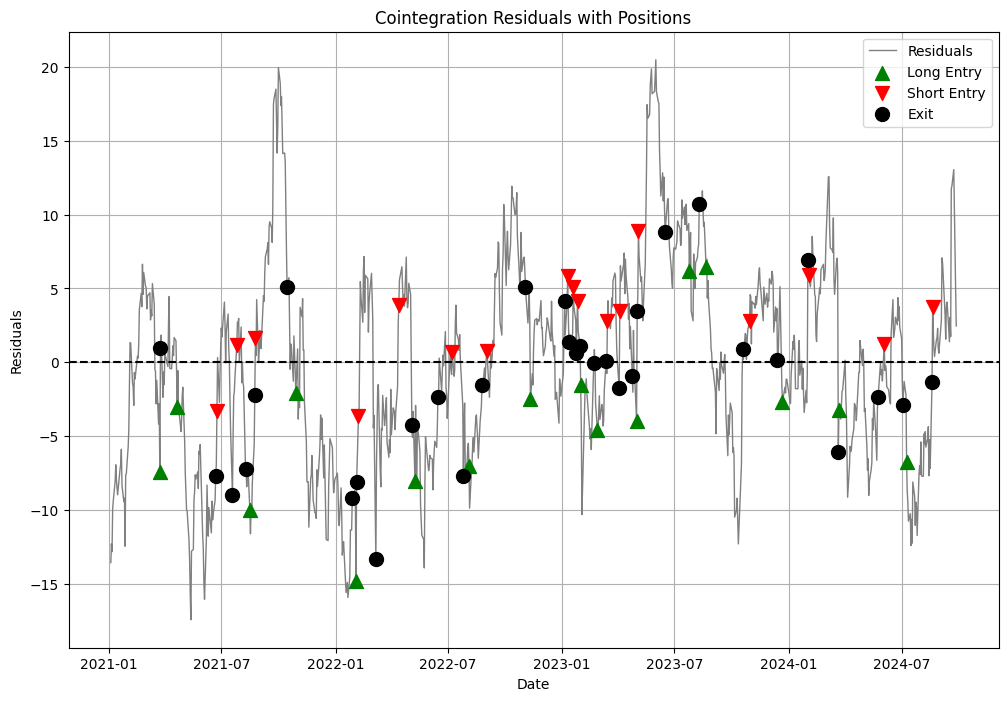

In [301]:
# Plot residuals with positions
def plot_residuals_with_positions(residuals, positions):
    plt.figure(figsize=(12, 8))
    plt.plot(residuals.index, residuals, label="Residuals", color='gray', linewidth=1)

    # Plot long, short, and exit positions
    long_positions = [i for pos, i in positions if pos == 'long']
    short_positions = [i for pos, i in positions if pos == 'short']
    exit_positions = [i for pos, i in positions if pos == 'exit']

    plt.scatter(residuals.index[long_positions], residuals.iloc[long_positions], color='green', marker='^', label='Long Entry', s=100, zorder=5)
    plt.scatter(residuals.index[short_positions], residuals.iloc[short_positions], color='red', marker='v', label='Short Entry', s=100, zorder=5)
    plt.scatter(residuals.index[exit_positions], residuals.iloc[exit_positions], color='black', marker='o', label='Exit', s=100, zorder=5)

    plt.axhline(0, color='black', linestyle='--')
    plt.title("Cointegration Residuals with Positions")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function with the ratio and positions from the backtest
plot_residuals_with_positions(residuals[-len(stock1_prices):], positions)